In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas  as gpd
import numpy as np
import pandas as pd

from sodapy import Socrata
import contextily as ctx

import esda
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import libpysal.weights as weights

import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
data = pd.read_csv('Sto_dfpcaParam.csv', index_col = 0)
data = data.sort_values(by='FID_grid')
data = data.rename(columns={'Weekend..x..Summer':'Wkend.x.Sum', 'Dist_center..pca..Other_lur':'Dis.pca.Oth_lur', 
                            'Dist_center..x..AreaProx': 'Dis.x.ArPrx'})
data["x"] = data["x"].apply(lambda x: np.around(x, decimals=4))
data["y"] = data["y"].apply(lambda x: np.around(x, decimals=2))
data

,FID_grid,x,y,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,Resi_lur,...,Rd_Pri,Dist_center,Summer,Winter,Spring,Weekend,trip_count,Dis.pca.Oth_lur,Wkend.x.Sum,Dis.x.ArPrx
1,9,671201.8641,6575992.31,0.086472,157,1.000010,1439.900816,2082.456266,0.000010,0.052529,...,0.000000,5946.427499,0,1,0,0,7,-2.404337,1,788.720664
2,10,671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,0.299365,...,0.000000,5685.068161,0,1,0,0,34,-1.261247,1,1382.821078
3,10,671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,0.299365,...,0.000000,5685.068161,0,1,0,1,18,-1.261247,100,1382.821078
4,17,674401.8641,6575992.31,0.244780,75,0.182869,711.715352,1324.557886,0.817151,0.363444,...,0.000000,4472.135955,0,1,0,0,35,0.039045,1,691.509064
5,18,674801.8641,6575992.31,0.000010,90,1.000010,348.374199,2986.375820,0.000010,0.520001,...,0.000000,4418.144407,0,1,0,0,26,-0.892873,1,222.092242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,897,672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,0.274044,...,803.161512,6462.197769,1,0,0,1,155,-0.687237,10000,2191.210661
2989,897,672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,0.274044,...,803.161512,6462.197769,0,0,0,1,64,-0.687237,100,2191.210661
2985,897,672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,0.274044,...,803.161512,6462.197769,1,0,0,0,384,-0.687237,100,2191.210661
2986,897,672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,0.274044,...,803.161512,6462.197769,0,0,1,0,8,-0.687237,1,2191.210661


In [3]:
data.columns

Index(['FID_grid', 'x', 'y', 'Comm_lur', 'Income', 'T_Enable', 'Rd_Pedes',
       'Rd_Ter', 'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx', 'Other_lur',
       'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc', 'Public_lur', 'Rd_Sec',
       'Rd_Pri', 'Dist_center', 'Summer', 'Winter', 'Spring', 'Weekend',
       'trip_count', 'Dis.pca.Oth_lur', 'Wkend.x.Sum', 'Dis.x.ArPrx'],
      dtype='object')

In [4]:
df = gpd.read_file(filepath)
df = df[['NEAR_FID','geometry']]
df = df.rename(columns={'NEAR_FID':'FID_grid'})
df = df.sort_values(by='FID_grid')
df = df.merge(data, how="inner", on=["FID_grid"])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df = df.dropna()
df = df.sort_values(by='FID_grid')
df

,FID_grid,geometry,x,y,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,...,Rd_Pri,Dist_center,Summer,Winter,Spring,Weekend,trip_count,Dis.pca.Oth_lur,Wkend.x.Sum,Dis.x.ArPrx
0,9,"POLYGON ((670601.864 6575792.310, 670601.864 6...",671201.8641,6575992.31,0.086472,157,1.000010,1439.900816,2082.456266,0.000010,...,0.000000,5946.427499,0,1,0,0,7,-2.404337,1,788.720664
1,10,"POLYGON ((671001.864 6575792.310, 671001.864 6...",671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,...,0.000000,5685.068161,0,1,0,0,34,-1.261247,1,1382.821078
2,10,"POLYGON ((671001.864 6575792.310, 671001.864 6...",671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,...,0.000000,5685.068161,0,1,0,1,18,-1.261247,100,1382.821078
3,17,"POLYGON ((673801.864 6575792.310, 673801.864 6...",674401.8641,6575992.31,0.244780,75,0.182869,711.715352,1324.557886,0.817151,...,0.000000,4472.135955,0,1,0,0,35,0.039045,1,691.509064
4,18,"POLYGON ((674201.864 6575792.310, 674201.864 6...",674801.8641,6575992.31,0.000010,90,1.000010,348.374199,2986.375820,0.000010,...,0.000000,4418.144407,0,1,0,0,26,-0.892873,1,222.092242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,897,"POLYGON ((672201.864 6586192.310, 672201.864 6...",672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,...,803.161512,6462.197769,0,0,0,1,64,-0.687237,100,2191.210661
2988,897,"POLYGON ((672201.864 6586192.310, 672201.864 6...",672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,...,803.161512,6462.197769,0,0,1,0,8,-0.687237,1,2191.210661
2984,897,"POLYGON ((672201.864 6586192.310, 672201.864 6...",672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,...,803.161512,6462.197769,0,0,0,0,160,-0.687237,1,2191.210661
2985,897,"POLYGON ((672201.864 6586192.310, 672201.864 6...",672801.8641,6586392.31,0.187988,191,0.277269,2079.427279,1605.035244,0.722751,...,803.161512,6462.197769,1,0,0,1,155,-0.687237,10000,2191.210661


In [6]:
df.columns

Index(['FID_grid', 'geometry', 'x', 'y', 'Comm_lur', 'Income', 'T_Enable',
       'Rd_Pedes', 'Rd_Ter', 'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx',
       'Other_lur', 'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc',
       'Public_lur', 'Rd_Sec', 'Rd_Pri', 'Dist_center', 'Summer', 'Winter',
       'Spring', 'Weekend', 'trip_count', 'Dis.pca.Oth_lur', 'Wkend.x.Sum',
       'Dis.x.ArPrx'],
      dtype='object')

In [7]:
now = df.crs
now

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - onshore and offshore.
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
df = df.to_crs(epsg=3857)
df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

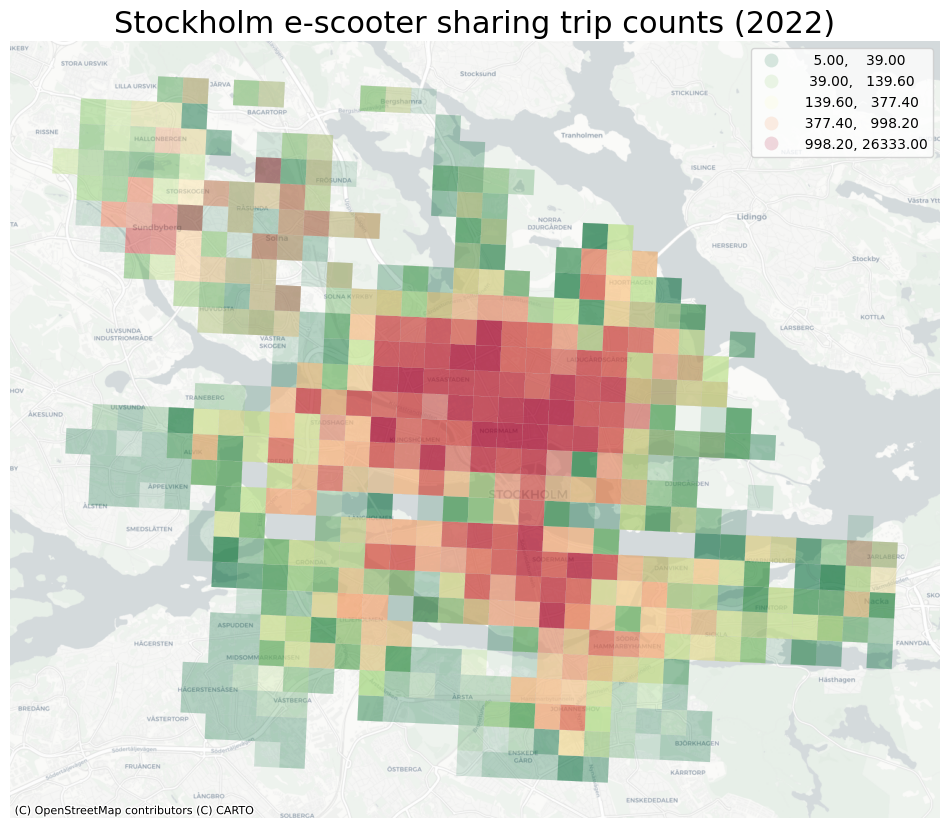

In [9]:
fig, ax = plt.subplots(figsize=(12,12))

df.plot(ax=ax, column='trip_count', legend=True, edgecolor='white',lw=0.1,   #color='black',
        alpha=0.15, cmap='RdYlGn_r', scheme='quantiles')

# no axis
ax.axis('off')
ax.set_title('Stockholm e-scooter sharing trip counts (2022)',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)    

# Global Spatial Autocorrelation

In [10]:
# spatial weights using knn, could also use distance
wq =  lps.weights.KNN.from_dataframe(df,k=8)
wq.transform = 'r'

# create a new column for the spatial lag
df['trip_lag'] = lps.weights.lag_spatial(wq, df['trip_count'])
df.head()

C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  warnings.warn(message)


,FID_grid,geometry,x,y,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,...,Dist_center,Summer,Winter,Spring,Weekend,trip_count,Dis.pca.Oth_lur,Wkend.x.Sum,Dis.x.ArPrx,trip_lag
0,9,"POLYGON ((2003196.322 8242575.428, 2003231.434...",671201.8641,6575992.31,0.086472,157,1.000010,1439.900816,2082.456266,0.000010,...,5946.427499,0,1,0,0,7,-2.404337,1,788.720664,25.750
1,10,"POLYGON ((2003976.792 8242540.218, 2004011.985...",671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,...,5685.068161,0,1,0,0,34,-1.261247,1,1382.821078,26.500
2,10,"POLYGON ((2003976.792 8242540.218, 2004011.985...",671601.8641,6575992.31,0.000010,177,1.000010,1065.726327,2166.682187,0.000010,...,5685.068161,0,1,0,1,18,-1.261247,100,1382.821078,28.500
3,17,"POLYGON ((2009439.835 8242291.453, 2009475.602...",674401.8641,6575992.31,0.244780,75,0.182869,711.715352,1324.557886,0.817151,...,4472.135955,0,1,0,0,35,0.039045,1,691.509064,19.875
4,18,"POLYGON ((2010220.235 8242255.587, 2010256.083...",674801.8641,6575992.31,0.000010,90,1.000010,348.374199,2986.375820,0.000010,...,4418.144407,0,1,0,0,26,-0.892873,1,222.092242,22.750


In [11]:
# surrounding average trip counts
df['trip_lag'].max()

9218.125

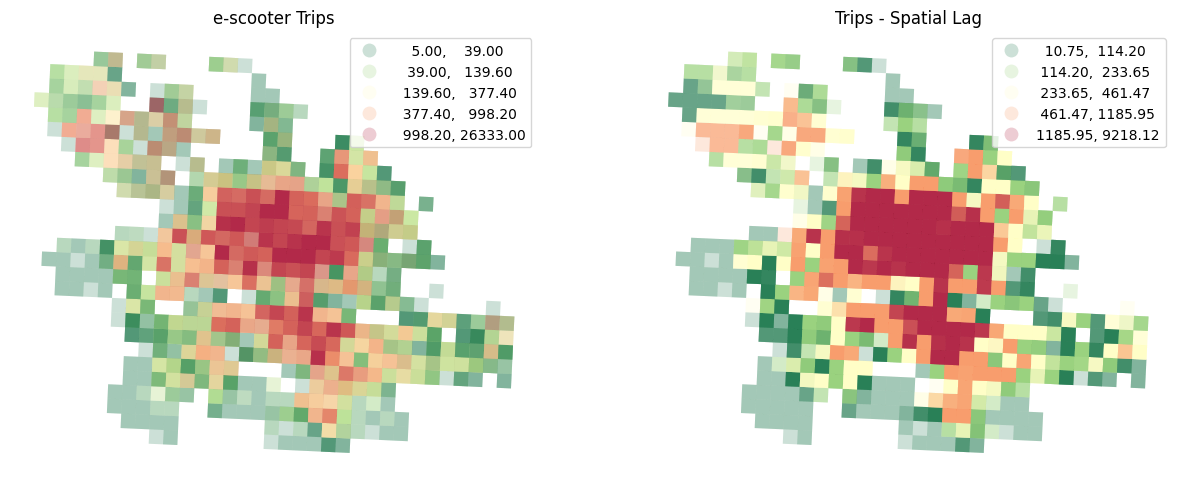

In [12]:
# Spatial lag map
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
df.plot(ax=ax[0], column='trip_count', cmap='RdYlGn_r', scheme='quantiles', k=5,legend=True,
         edgecolor='white', linewidth=0, alpha=0.20)


ax[0].axis("off")
ax[0].set_title("e-scooter Trips")

# spatial lag map on the right
df.plot(ax=ax[1],column='trip_lag', cmap='RdYlGn_r', scheme='quantiles', k=5,legend=True,
         edgecolor='white',linewidth=0, alpha=0.20 )

ax[1].axis("off")
ax[1].set_title("Trips - Spatial Lag")
plt.show()

# Morans I

In [13]:
y = df.trip_count
moran = Moran(y, wq)
moran.I                     # for 8 neighbors(k), we have value of 0.6394442786720297

0.4560265688016187

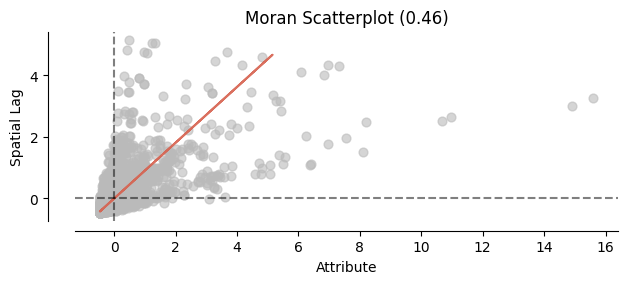

In [14]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

In [15]:
# plot_moran_simulation(moran,aspect_equal=False)
print('p-value: ', moran.p_sim, 'z-score: ', moran.z_sim)

p-value:  0.001 z-score:  53.801794847776925


In [16]:
df.columns

Index(['FID_grid', 'geometry', 'x', 'y', 'Comm_lur', 'Income', 'T_Enable',
       'Rd_Pedes', 'Rd_Ter', 'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx',
       'Other_lur', 'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc',
       'Public_lur', 'Rd_Sec', 'Rd_Pri', 'Dist_center', 'Summer', 'Winter',
       'Spring', 'Weekend', 'trip_count', 'Dis.pca.Oth_lur', 'Wkend.x.Sum',
       'Dis.x.ArPrx', 'trip_lag'],
      dtype='object')

In [17]:
import libpysal.weights as weights
w = weights.Queen.from_dataframe(df)
dfdrop = df.drop(['FID_grid','x','y','trip_lag','geometry','Dis.pca.Oth_lur', 'Wkend.x.Sum','Dis.x.ArPrx'],axis=1)

Moran_I_list = []
random_Z_list = []
random_Zp_list = []
norm_Z_list = []
norm_Zp_list = []
# global Moran's I
for i in range(1,22):
    y_name = dfdrop.columns[i]
    y = dfdrop[y_name]
    mi = Moran(y, w)
    
    Moran_I_list.append(mi.I)
    random_Z_list.append(mi.z_rand)
    random_Zp_list.append(mi.p_rand)
    norm_Z_list.append(mi.z_norm)
    norm_Zp_list.append(mi.p_norm) #sim

Moran_I_df = pd.DataFrame()
Moran_I_df['variables'], Moran_I_df['Moran_I'], Moran_I_df['z-score'], Moran_I_df['p-value'] = \
(dfdrop.columns[1:22], Moran_I_list, norm_Z_list, norm_Zp_list)
Moran_I_df = Moran_I_df.sort_values(by='Moran_I', ascending=False) 
Moran_I_df

C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,variables,Moran_I,z-score,p-value
16,Dist_center,0.979002,252.810473,0.000000e+00
0,Income,0.686925,177.412335,0.000000e+00
5,Resi_lur,0.559069,144.406930,0.000000e+00
2,Rd_Pedes,0.543826,140.472286,0.000000e+00
9,Edu_lur,0.409135,105.702500,0.000000e+00
7,AreaProx,0.403492,104.245600,0.000000e+00
6,Health_lur,0.401397,103.704751,0.000000e+00
8,Other_lur,0.385259,99.538884,0.000000e+00
3,Rd_Ter,0.371595,96.011767,0.000000e+00
14,Rd_Sec,0.351559,90.839465,0.000000e+00


C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 18 disconnected components.
  warnings.warn(message)


0.4560265688016187


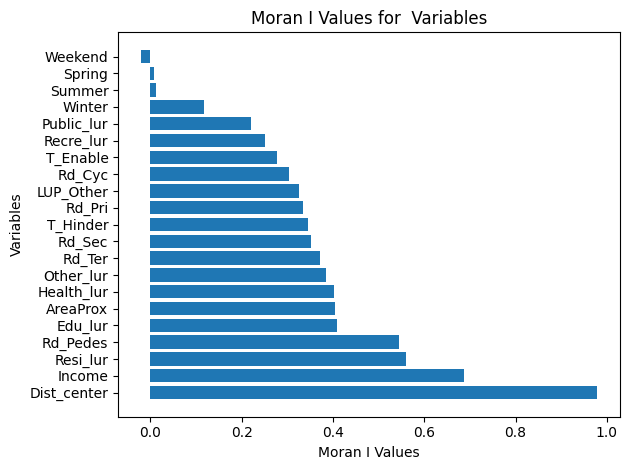

In [18]:
y = df.trip_count
wq =  lps.weights.KNN.from_dataframe(df,k=8)
moran = Moran(y, wq)
print(moran.I)    

variable_names = Moran_I_df['variables']
moran_i_values = Moran_I_df['Moran_I']
Moran_I_df = Moran_I_df.sort_values(by='Moran_I', ascending=False) 

# Create the bar plot
plt.barh(variable_names, moran_i_values)
plt.xlabel('Moran I Values')
plt.ylabel('Variables')
plt.title('Moran I Values for  Variables')

# Adjust the layout if needed
plt.tight_layout()

# Display the plot
plt.show()

# Local Spatial Autocorrelation

In [19]:
lisa = esda.moran.Moran_Local(y, wq)

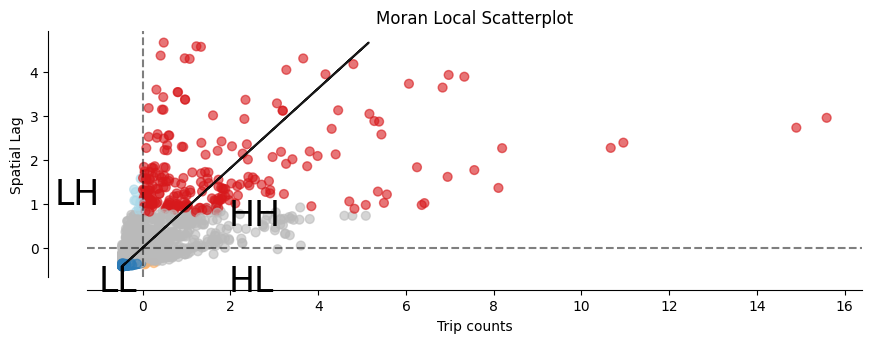

In [20]:
fig,ax = plt.subplots(figsize=(10,8))

moran_scatterplot(lisa, ax=ax, p=0.02)
ax.set_xlabel("Trip counts")
ax.set_ylabel('Spatial Lag')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

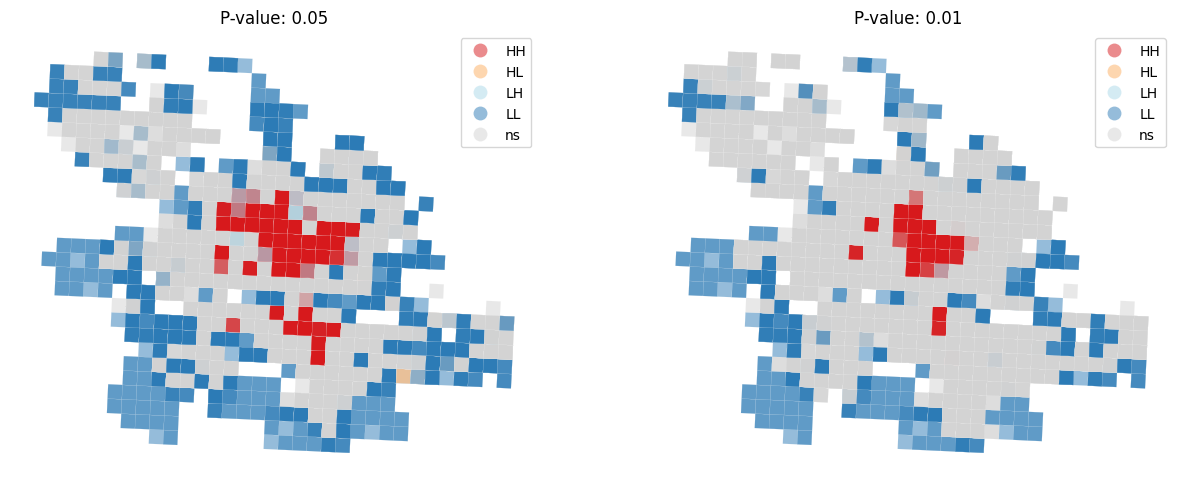

In [21]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# regular count map on the left
lisa_cluster(lisa, df, p=0.05, alpha=0.5,ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, df, p=0.01, alpha=0.5,ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

# Correlation

In [22]:
df.head(2)

,FID_grid,geometry,x,y,Comm_lur,Income,T_Enable,Rd_Pedes,Rd_Ter,T_Hinder,...,Dist_center,Summer,Winter,Spring,Weekend,trip_count,Dis.pca.Oth_lur,Wkend.x.Sum,Dis.x.ArPrx,trip_lag
0,9,"POLYGON ((2003196.322 8242575.428, 2003231.434...",671201.8641,6575992.31,0.086472,157,1.00001,1439.900816,2082.456266,0.00001,...,5946.427499,0,1,0,0,7,-2.404337,1,788.720664,25.75
1,10,"POLYGON ((2003976.792 8242540.218, 2004011.985...",671601.8641,6575992.31,0.000010,177,1.00001,1065.726327,2166.682187,0.00001,...,5685.068161,0,1,0,0,34,-1.261247,1,1382.821078,26.50


In [23]:
df.columns

Index(['FID_grid', 'geometry', 'x', 'y', 'Comm_lur', 'Income', 'T_Enable',
       'Rd_Pedes', 'Rd_Ter', 'T_Hinder', 'Resi_lur', 'Health_lur', 'AreaProx',
       'Other_lur', 'Edu_lur', 'LUP_Other', 'Recre_lur', 'Rd_Cyc',
       'Public_lur', 'Rd_Sec', 'Rd_Pri', 'Dist_center', 'Summer', 'Winter',
       'Spring', 'Weekend', 'trip_count', 'Dis.pca.Oth_lur', 'Wkend.x.Sum',
       'Dis.x.ArPrx', 'trip_lag'],
      dtype='object')

In [24]:
df1 = df[['Comm_lur','Income','T_Enable','Rd_Pedes','Rd_Ter','T_Hinder','Resi_lur','Health_lur','AreaProx','Other_lur',
          'Edu_lur','LUP_Other','Recre_lur','Rd_Cyc','Public_lur','Rd_Sec','Rd_Pri','Dist_center','Summer','Winter',
          'Spring', 'Weekend','Wkend.x.Sum','Dis.x.ArPrx', 'trip_count']]

In [25]:
corr_matrix = df1.corr().round(2)

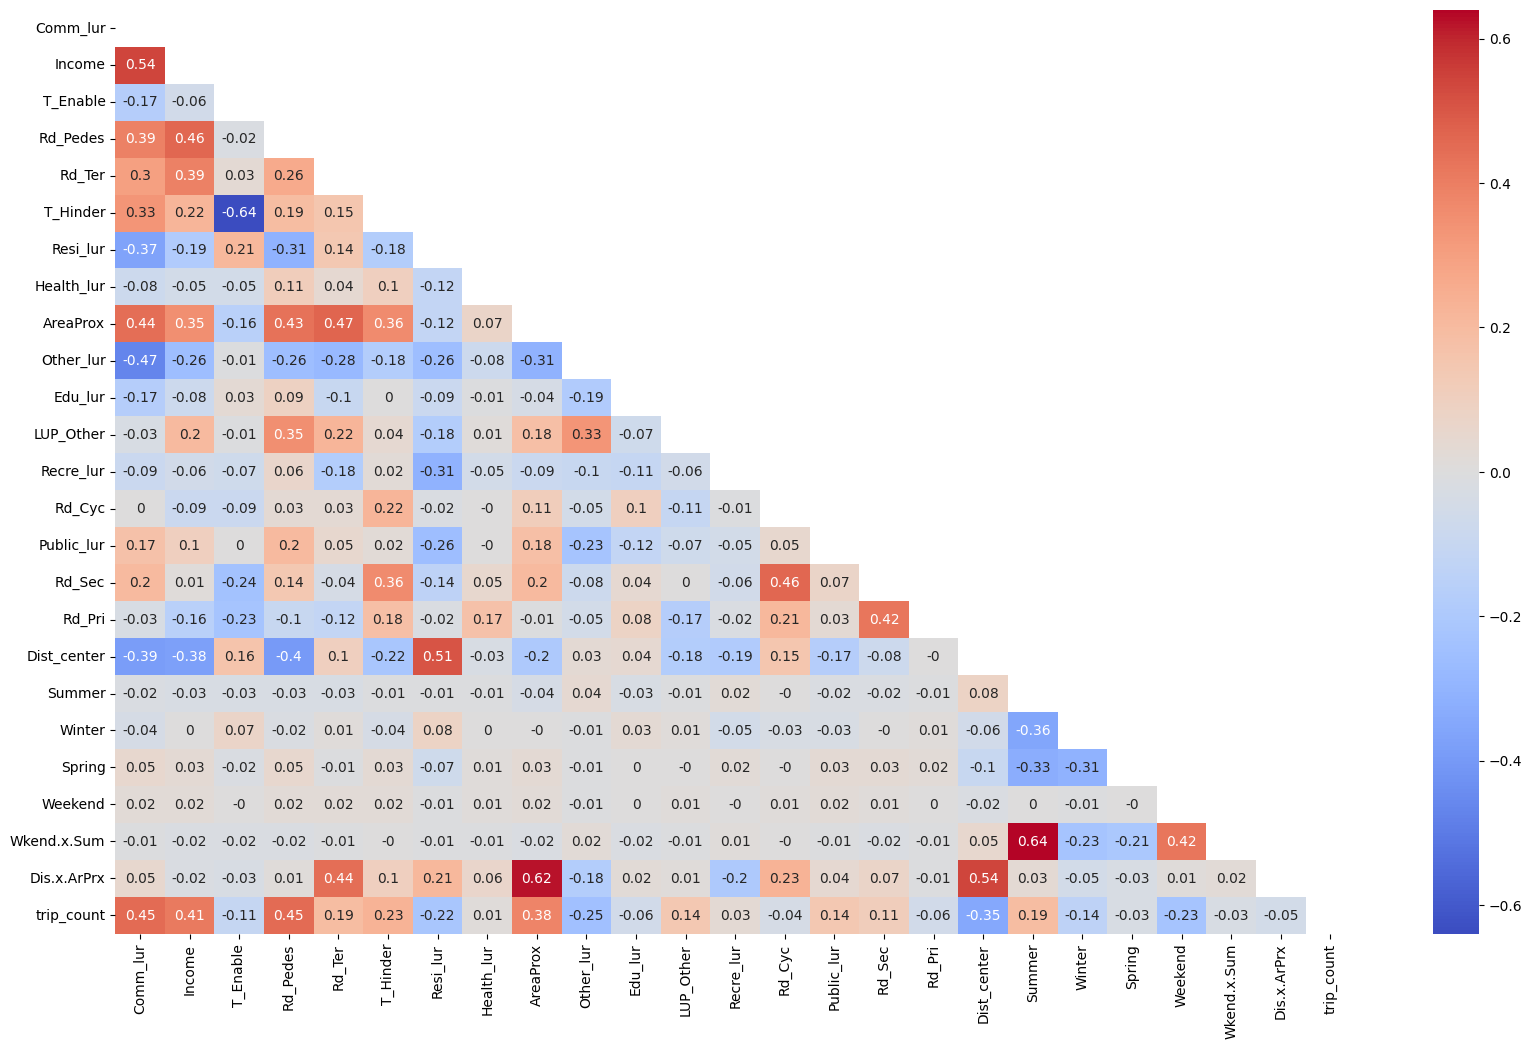

In [28]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
plt.show()